In [2]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pysm3
import pysm3.units as u
%matplotlib inline

Using PySM3 to simulate foreground and cmb maps. The noise is simulated as a random process and linked to the noise sensitivity of Planck

In [3]:
#simulating foregroud emission and noise at the different Planck frequencies

nside = 128
#lmax =200 #maximum multipole moment

# Planck frequencies (in GHz)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0,  545.0,  857.0])
n_freqs = len(freqs)

# Planck noise sensitivity (in uK_arcmin)
sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])

#Importing models for foregrounds and cmb using pysm sky module

sky_d = pysm3.Sky(nside=nside, preset_strings=["d1"])
sky_s = pysm3.Sky(nside=nside, preset_strings=["s1"])
sky_f = pysm3.Sky(nside=nside, preset_strings=["f1"])
sky_cmb = pysm3.Sky(nside=nside, preset_strings=["c1"])

# Initialization of lists to collect maps of different components at different frequencies
noise_pl = []
dust_pl = []
sync_pl = []
ff_pl = []
cmb_pl =[]
for nf in range(n_freqs):
    #noise
    noise= (np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True))
    noise_pl.append(noise)
    #foregrounds
    dust= sky_d.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    dust_pl.append(dust)
    sync=sky_s.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))

    sync_pl.append(sync)
    ff=sky_f.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    ff_pl.append(ff)
    #cmb
    cmb = sky_cmb.get_emission(freqs[nf] * u.GHz)[0]* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    cmb_pl.append(cmb)


# Making lists numpy arrays. Their dimension is (N_freq,N_pixels).
noise_pl=np.array(noise_pl)
dust_pl=np.array(dust_pl)
sync_pl=np.array(sync_pl)
ff_pl=np.array(ff_pl)
cmb_pl = np.array(cmb_pl)


Combining the CMB and foreground maps to be input into ILC

In [4]:
maps_pl = cmb_pl + noise_pl + dust_pl + sync_pl + ff_pl #cmb and foregrounds combined
fgds_pl= dust_pl + sync_pl + ff_pl #combined foregrounds
print(maps_pl.shape)

(9, 196608)


Transforimng frequency maps to harmonic space by decomposition

In [5]:
#transform maps to spherical harmonics
lmax=3*nside -1 #default is lmax= 3*nside+1
almsize=hp.Alm.getsize(lmax)
print(almsize)
print((lmax+1)**2)
print(lmax)
alm_maps=np.zeros((n_freqs, almsize), dtype=complex) #storing coefficients in an array of dim n_freqs*almsize. dtype is complex to account for -ive values
alm_fgds= np.zeros((n_freqs, almsize), dtype=complex)
for nf in range(n_freqs):
    alm_maps[nf,:]= hp.map2alm(maps_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) #record alm corresponding to each f for a corresponding l and m
    alm_fgds[nf,:]= hp.map2alm(fgds_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False)

73920
147456
383


In [6]:
# alm contains a_lm(i) coefficients
print(alm_maps.shape) 
print(alm_fgds.shape) # Outputs: (lmax + 1)*(lmax + 2)//2, the number of coefficients
num_maps= len(alm_maps)
num_fgds= len(alm_fgds)
print(num_maps)

(9, 73920)
(9, 73920)
9


First Method:

Compute nf x nf Covariance matrix by fixing l for particular $a_{lm}$. Compute weights for every l

$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [7]:
C_l= np.zeros((lmax+1,n_freqs, n_freqs), dtype=float)#lmax+1 x freq x freq
for l in range(lmax+1):
    index= np.zeros((l+1), dtype=int) 
    for m in range(l+1):
        index[m]=hp.Alm.getidx(lmax, l,m) #getting indices corresponding to each l and m for m>0
    
   
    alm_p=alm_maps[:, index] #subarray of alm maps. : takes all values from first dim (frequencies). 2nd dim the values of m>0


    #alm = np.conj(alm_p) + alm_p #alm with positive and negative values

    C_l [l,:, :]= np.real(np.outer(alm_p[:, 0], alm_p[:,0])) #2d array from outer product alm_0
    
    for m in range(1,l+1): #sum over m
        C_l [l,:, :] += 2* np.real(np.outer(alm_p[:, m], np.conj(alm_p[:, m]))) #adding alm_p and negative ti C_l . outer product/multiplying over freq
C_l /= (2*l +1)   

print(alm_p.shape)
print(C_l.shape)
#print(alm.shape)
    #for nf in range(n_freqs):
    #enumerate function
        #alm_p[nf,i]= alm_maps[nf,index]  #storing the alm in a 1d array corresponding to every freq
 

(9, 384)
(384, 9, 9)


Now we can compute the inverse covariance matrix and compute the weights using $$\omega_i(l) = \frac{\sum_j (C_l^{-1})_{ij} b_{j}}{\sum_{ij}b_i (C_l^{-1})_{ij} b_{j}}$$

where $b_i $ represents the CMB transfer function. $b_i = [1,...,1]$

In [8]:
#CMB spectral energy density
b= np.ones(n_freqs, dtype=float ) #array filled with values of 1. column vector

w= np.zeros((n_freqs, lmax+1), dtype=float) #weights

Cl_inv =np.zeros((n_freqs, n_freqs), dtype=float)

for l in range(lmax+1):

    Cl_matrix =  C_l[l,:,:] #cov matrix for a specific l (nfreqs x nfreqs)
    

    Cl_inv[:,:] = np.linalg.pinv(Cl_matrix[:,:]) #(nfreqs x nfreqs)
    numerator = np.dot(Cl_inv,  b) #nfreqs x 1
    b_trans = b.T
    denominator = np.dot(b_trans, np.dot( Cl_inv, b)) #scalar?? 1x1
  

    for nf in range(n_freqs):
      w[:, l] = numerator[:]/denominator# (nfreqs x m) Since this is inside l loop it is only the weight for a specific l. looping will give us the correct shape?
print(Cl_matrix.shape)
print(Cl_inv.shape)
print(numerator.shape)
print(denominator.shape)
print(w.shape) #nf x m array
#issue in dividing? values too small

(9, 9)
(9, 9)
(9,)
()
(9, 384)


Sum over frequencies to get $a_{ILC}$ for every l weighted sum across all frequencies for each m to get a cleaned spherical harmonic coefficient alm for each m at a given l.

$$a^{ILC}_{lm} = \sum_i w_i(l)a^i_{lm}$$

In [9]:
alm_ilc = np.zeros((almsize), dtype=complex)

for l in range(lmax +1):
    index= np.zeros((l+1), dtype=int)
    for m in range(l+1):
        index[m]= hp.Alm.getidx(lmax, l, m)
    alm_p = alm_maps[:, index]

    alm = np.dot(w[:,l], alm_p[:,:]) # multiplying (9x384) and (9x1) to get (384x1)=this is for one l (m =0-> l). we iterate over all l
    '''
    #summing over frequencies. and taking ALL m values for a fixed l. Looping over l means 
    so we get an alm weighted by contributions from all frequencies over all scales.
    this should be the same as writing alm_p??
    '''
    alm_ilc[index]= alm #putting alm values back into an array corresponding to their proper positions. flat array
    
print(alm.shape)
print(alm_ilc.shape)

(384,)
(73920,)


Converting back to pixel space

In [10]:
maps_out = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)
print(maps_out.shape)

(196608,)


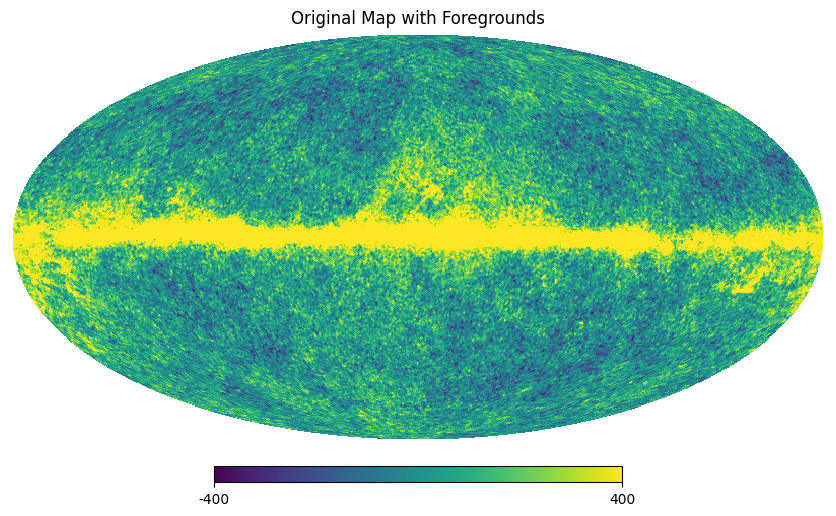

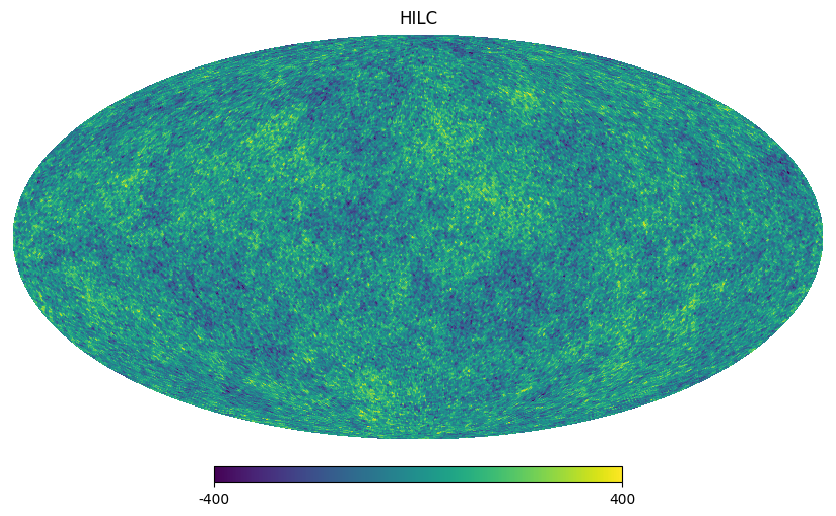

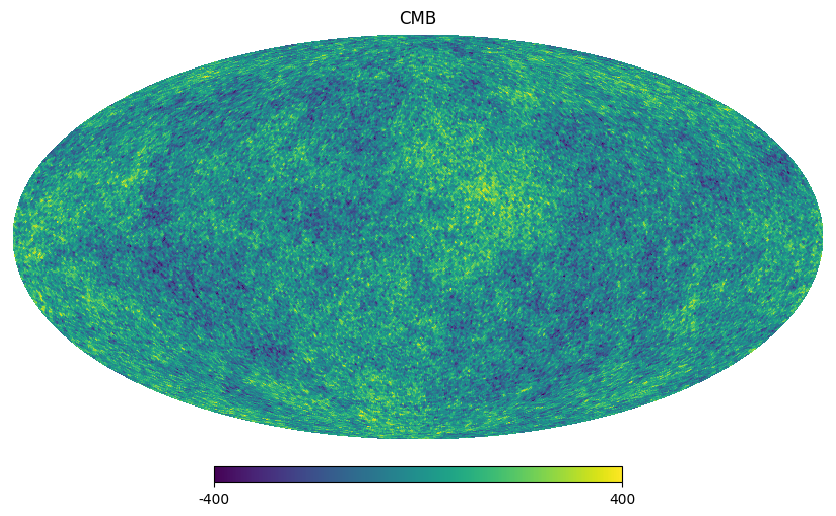

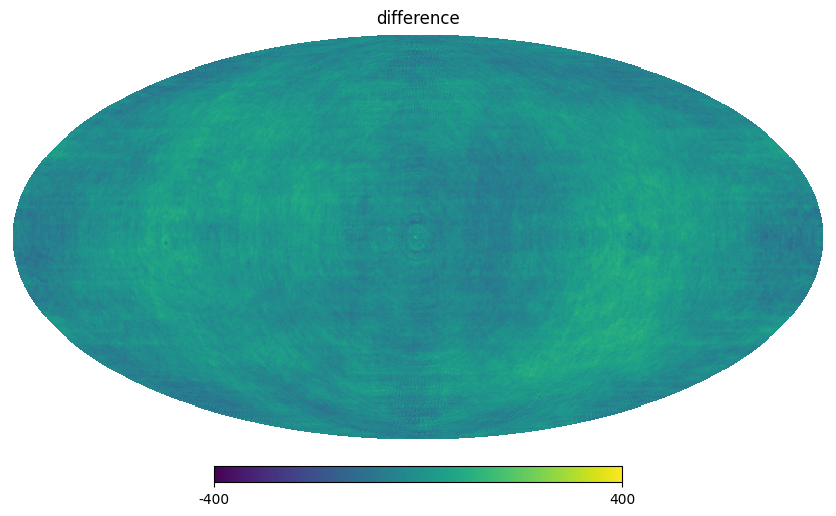

In [14]:
hp.mollview(maps_pl[4], title="Original Map with Foregrounds", min=-400, max=400) #comparison to uncleaned
ilc =maps_out-np.mean(maps_out)
diff = ilc - cmb_pl[4]
hp.mollview(ilc, title= "HILC", min=-400, max=400)
hp.mollview(cmb_pl[4],title ="CMB", min=-400, max=400)
hp.mollview(diff,title ="difference", min=-400, max=400)


ALTERNATE METHOD

Compute nf x nf Covariance matrix by fixing l for particular $a_{lm}$. Compute weights for every l

$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [12]:
#Alternate method
Cl= np.zeros((lmax+1,n_freqs, n_freqs), dtype=float) 
#alm = np.zeros ((n_freqs, almsize), dtype=complex)


for l in range(lmax+1): #for every l
    
    #index already obtained in first method do not need to do it again?
    index= np.zeros((l+1), dtype=int) 
    for m in range(l+1):
        index[m]=hp.Alm.getidx(lmax, l,m) #getting indices corresponding to each l and m for m>0
    
   
    alm_p=alm_maps[:, index] #subarray of alm maps. : takes all values from first dim (frequencies). 2nd dim the values of m>0

    #Cl [l,:,:]= np.real(np.outer(alm_p[:, 0], alm_p[:,0]))

    #when using einsum no need to loop over m

    alm_n = np.conj(alm_p[:,1:]) #get rid of zeroth value
    
    alm = np.concatenate((alm_p, alm_n), axis=1)  # Concatenates along the second axis. Here we have zeroth value in almp


    alm_conj= np.conj(alm)
    alm_trans= alm_conj.T

    Cl[l,:,:]+= (np.real(np.einsum('il, lj-> ij', alm, alm_trans))) #tensor multiplication over all values of m
    #Cl[l,:,:] /= (2*l +1)

print(alm_p.shape)
print(alm_n.shape)
print(alm_trans.shape)
print(alm.shape)
print(Cl.shape)

(9, 384)
(9, 383)
(767, 9)
(9, 767)
(384, 9, 9)


Check if cov matrix is the same for both methods

In [13]:
np.allclose(Cl, C_l)

False